# Introduction

*   Our data consists of a set of Reddit comments where each comment has been manually labeled with one or multiple emotions. 

*   Our main objective is to build a text classification model that allows us to detect emotions in a given text.

*   In this notebook, we will focus on exploring our data and processing it in order to prepare for the modeling steps.

# 1 - Importing libraries and loading data

First, let's install and import some libraries for data exploration and  processing.

In [1]:
# Installing additional libraries for text preprocessing
!pip install emoji
!pip install contractions

In [2]:
!pip install spacy

In [3]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import json
from pprint import pprint

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Text processing libraries
import emoji
import re
import contractions
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

Data has already been split into train, validation and test datasets labeled with one or multiple emotions. Let's import them into pandas dataframes.

In [7]:
# Importing raw comments and labels
df_train = pd.read_csv('C:/Users/Lenovo/Desktop/Machine Learning/Final Project/text_emotions_detection-main/text_emotions_detection-main/data/train.tsv', sep='\t', header=None, names=['Text', 'GE_indices', 'Id']).drop('Id', axis=1)
df_val = pd.read_csv('C:/Users/Lenovo/Desktop/Machine Learning/Final Project/text_emotions_detection-main/text_emotions_detection-main/data/dev.tsv', sep='\t', header=None, names=['Text', 'GE_indices', 'Id']).drop('Id', axis=1)
df_test = pd.read_csv('C:/Users/Lenovo/Desktop/Machine Learning/Final Project/text_emotions_detection-main/text_emotions_detection-main/data/test.tsv', sep='\t', header=None, names=['Text', 'GE_indices', 'Id']).drop('Id', axis=1)

# Preview of data
display(df_train.head())

,Text,GE_indices
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


Now let's define some size variables and see how many samples we have in each dataset and also the total number of samples.

In [8]:
# Defining the number of samples in train, validation and test dataset
size_train = df_train.shape[0]
size_val = df_val.shape[0]
size_test = df_test.shape[0]

# Defining the total number of samples
size_all = size_train + size_val + size_test

In [9]:
# Shape of train, validation and test datasets
print("Train dataset has {} samples and represents {:.2f}% of overall data".format(size_train, size_train/size_all*100))
print("Validation dataset has {} samples and represents {:.2f}% of overall data".format(size_val, size_val/size_all*100))
print("Test dataset has {} samples and represents {:.2f}% of overall data".format(size_test, size_test/size_all*100))
print()
print("The total number of samples is : {}".format(size_all))

Train dataset has 43410 samples and represents 80.00% of overall data
Validation dataset has 5426 samples and represents 10.00% of overall data
Test dataset has 5427 samples and represents 10.00% of overall data

The total number of samples is : 54263


# 2 - Labels processing

Our data has been labeled using the indices of each emotion in the GoEmotions taxonomy (from 0 to 27)in a text format. Also, in the case of multi-label samples, indices were separated by a ",".

The objectif of this section is to transform the labels into a format that can be fed to multi-label classification algorithms (One-hot encoding).

In [10]:
# Display some useful information about our data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        43410 non-null  object
 1   GE_indices  43410 non-null  object
dtypes: object(2)
memory usage: 678.4+ KB


## 2.1 - GoEmotions Taxonomy

Now, let's load the emotions in the GoEmotions taxonomy.

In [11]:
# Loading emotion labels for GoEmotions taxonomy
with open("C:/Users/Lenovo/Desktop/Machine Learning/Final Project/text_emotions_detection-main/text_emotions_detection-main/data/emotions.txt", "r") as file:
    GE_taxonomy = file.read().split("\n")

for emo in GE_taxonomy:
  print(emo)

admiration
amusement
anger
annoyance
approval
caring
confusion
curiosity
desire
disappointment
disapproval
disgust
embarrassment
excitement
fear
gratitude
grief
joy
love
nervousness
optimism
pride
realization
relief
remorse
sadness
surprise
neutral


In [12]:
# Number of emotions
print("We have {} emotions in GoEmotions taxonomy including 'Neutral'".format(len(GE_taxonomy)))

We have 28 emotions in GoEmotions taxonomy including 'Neutral'


## 2.2 - Labels encoding

Before starting to encode our labels, we can concatenate our three datasets into one global dataset, perform all the processings we want and separate them later on using the size variables we defined earlier.

However, it is important here to keep track of the order in which the datasets will be concatenated.

In [13]:
# Concatenating the 3 datasets for labels preprocessing
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)

# Preview of data
display(df_all.head(3))

print(df_all.shape)

,Text,GE_indices
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2


(54263, 2)


We can now begin to encode our emotions using the following procedure:


1.  Convert the indices into lists of indices using the comma separator 
2.  Map each index to the actual emotion label (each index corresponds to the index of each emotion in the `GE_taxonomy` list
3.  Use One-Hot encoding



In [14]:
# Convertings emotion indices into list of indices
df_all['GE_indices'] = df_all['GE_indices'].apply(lambda x: x.split(','))

# Preview of data
display(df_all.head(3))

,Text,GE_indices
0,My favourite food is anything I didn't have to...,[27]
1,"Now if he does off himself, everyone will thin...",[27]
2,WHY THE FUCK IS BAYLESS ISOING,[2]


In [16]:
# Defining a function that maps each index to emotion labels
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(GE_taxonomy[int(i)])
    return arr

# Applying the function
df_all['GE_labels'] = df_all['GE_indices'].apply(idx2class)

# Preview of data
display(df_all.head(3))

,Text,GE_indices,admiration,GE_labels
0,My favourite food is anything I didn't have to...,[27],0.0,[neutral]
1,"Now if he does off himself, everyone will thin...",[27],0.0,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[2],0.0,[anger]


In [17]:
# OneHot encoding for multi-label classification
for emo in GE_taxonomy:
    df_all[emo] = np.zeros((len(df_all),1))
    df_all[emo] = df_all['GE_labels'].apply(lambda x: 1 if emo in x else 0)

# Preview of data   
display(df_all.head(3))

,Text,GE_indices,admiration,GE_labels,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,[27],0,[neutral],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],0,[neutral],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],0,[anger],0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Keeping only necessary columns
df_all = df_all.drop(['GE_indices','GE_labels'], axis=1)

# Preview of data   
display(df_all.head(3))

,Text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3 - Text preprocessing

Now that we have delt with the labels, we can start cleaning the text corpus.

Given the source of data (Reddit), our samples need to be curated in order to harmonize them and prepare them for the modeling step.

For example, we need to handle emojis, contractions, acronyms, special characters, etc.

Let's first visualize a random sample.

In [19]:
# Visualising a random text sample from our dataset
text_sample = np.random.randint(len(df_all))
print(df_all.loc[text_sample, "Text"])

Fake Fans in hiding now haha


We can now define a function that will be applied to all our samples.

This function has been constructed based on the analysis of a subsample of our train dataset, and it can obviously be further improved.

In [20]:
# Building a preprocessing function to clean text
def preprocess_corpus(x):

  # Adding a space between words and punctation
  x = re.sub( r'([a-zA-Z\[\]])([,;.!?])', r'\1 \2', x)
  x = re.sub( r'([,;.!?])([a-zA-Z\[\]])', r'\1 \2', x)
  
  # Demojize
  x = emoji.demojize(x)
  
  # Expand contraction
  x = contractions.fix(x)
  
  # Lower
  x = x.lower()

  #correct some acronyms/typos/abbreviations  
  x = re.sub(r"lmao", "laughing my ass off", x)  
  x = re.sub(r"amirite", "am i right", x)
  x = re.sub(r"\b(tho)\b", "though", x)
  x = re.sub(r"\b(ikr)\b", "i know right", x)
  x = re.sub(r"\b(ya|u)\b", "you", x)
  x = re.sub(r"\b(eu)\b", "europe", x)
  x = re.sub(r"\b(da)\b", "the", x)
  x = re.sub(r"\b(dat)\b", "that", x)
  x = re.sub(r"\b(dats)\b", "that is", x)
  x = re.sub(r"\b(cuz)\b", "because", x)
  x = re.sub(r"\b(fkn)\b", "fucking", x)
  x = re.sub(r"\b(tbh)\b", "to be honest", x)
  x = re.sub(r"\b(tbf)\b", "to be fair", x)
  x = re.sub(r"faux pas", "mistake", x)
  x = re.sub(r"\b(btw)\b", "by the way", x)
  x = re.sub(r"\b(bs)\b", "bullshit", x)
  x = re.sub(r"\b(kinda)\b", "kind of", x)
  x = re.sub(r"\b(bruh)\b", "bro", x)
  x = re.sub(r"\b(w/e)\b", "whatever", x)
  x = re.sub(r"\b(w/)\b", "with", x)
  x = re.sub(r"\b(w/o)\b", "without", x)
  x = re.sub(r"\b(doj)\b", "department of justice", x)
  
  #replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
  x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
  x = re.sub(r"\b(co+l+)\b", "cool", x)
  x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
  x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
  x = re.sub(r"\b(o+m+g+)\b", "omg", x)
  x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
  x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
  x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
  x = re.sub(r"\b(w+o+w+)\b", "wow", x)
  x = re.sub(r"\b(w+h+y+)\b", "why", x)
  x = re.sub(r"\b(s+o+)\b", "so", x)
  x = re.sub(r"\b(f)\b", "fuck", x)
  x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
  x = re.sub(r"\b(ofc)\b", "of course", x)
  x = re.sub(r"\b(the us)\b", "usa", x)
  x = re.sub(r"\b(gf)\b", "girlfriend", x)
  x = re.sub(r"\b(hr)\b", "human ressources", x)
  x = re.sub(r"\b(mh)\b", "mental health", x)
  x = re.sub(r"\b(idk)\b", "i do not know", x)
  x = re.sub(r"\b(gotcha)\b", "i got you", x)
  x = re.sub(r"\b(y+e+p+)\b", "yes", x)
  x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
  x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
  x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
  x = re.sub(r"\b(o+h+)\b", "oh", x)
  x = re.sub(r"\b(a+h+)\b", "ah", x)
  x = re.sub(r"\b(u+h+)\b", "uh", x)

  # Handling emojis
  x = re.sub(r"<3", " love ", x)
  x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
  x = re.sub(r":\)", " smiling_face ", x)
  x = re.sub(r"^_^", " smiling_face ", x)
  x = re.sub(r"\*_\*", " star_struck ", x)
  x = re.sub(r":\(", " frowning_face ", x)
  x = re.sub(r":\^\(", " frowning_face ", x)
  x = re.sub(r";\(", " frowning_face ", x)
  x = re.sub(r":\/",  " confused_face", x)
  x = re.sub(r";\)",  " wink", x)
  x = re.sub(r">__<",  " unamused ", x)
  x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
  x = re.sub(r"\b(n+a+h+)\b", "no", x)

  # Handling special cases of text
  x = re.sub(r"h a m b e r d e r s", "hamberders", x)
  x = re.sub(r"b e n", "ben", x)
  x = re.sub(r"s a t i r e", "satire", x)
  x = re.sub(r"y i k e s", "yikes", x)
  x = re.sub(r"s p o i l e r", "spoiler", x)
  x = re.sub(r"thankyou", "thank you", x)
  x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

  # Remove special characters and numbers replace by space + remove double space
  x = re.sub(r"\b([.]{3,})"," dots ", x)
  x = re.sub(r"[^A-Za-z!?_]+"," ", x)
  x = re.sub(r"\b([s])\b *","", x)
  x = re.sub(r" +"," ", x)
  x = x.strip()

  return x

Our function is ready ! let's clean the data and see few samples.

In [21]:
# Applying the preprocessing function on the dataset
df_all["Clean_text"] = df_all["Text"].apply(preprocess_corpus)

# Preview of data
display(df_all[['Text', 'Clean_text']].sample(5))

,Text,Clean_text
53330,"it’s not something you get over, but it’s some...",it is not something you get over but it is som...
24661,I am so relieved,i am so relieved
20526,Got the same pops! [NAME] a lot :) too bad I c...,got the same pops ! name a lot smiling_face to...
44635,The lies of this evangelical “[RELIGION]” woma...,the lies of this evangelical religion woman ar...
44026,So many great shows they killed because they d...,so many great shows they killed because they d...


This looks ok ! Now let's get rid of the original texts.

In [22]:
# Dropping raw text column
df_all = df_all[ ['Clean_text'] + [ col for col in df_all.columns if col not in ['Text', 'Clean_text'] ] ]

# Preview of data   
display(df_all.head(3))

,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4 - Exploratory Data Analysis

Our data is clean ! We can now try to perform a deeper analysis. But before that, let's go back and split the data into train, validation and test splits.

In [23]:
# Building a function that will divide in train, validation and test sets
def get_train_val_test(df):
    train = df.iloc[:size_train, :]
    val = df.iloc[size_train:size_train+size_val, :]
    test = df.iloc[size_train+size_val:size_train+size_val+size_test, :]
    return train, val, test

In [24]:
# Dividing back in train, validation and test datasets (GoEmotions)
train_GE, val_GE, test_GE = get_train_val_test(df_all)
print(train_GE.shape)
print(val_GE.shape)
print(test_GE.shape)

(43410, 29)
(5426, 29)
(5427, 29)


## 4.1 - Labels analysis

### 4.1.1 - Number of emotions per sample in the dataset

As we said earlier, a sample can be annotated using multiple emotions. An interesting thing to do is to see what is the range in terms of number of emotions in our data, and see how many samples we have in each case.

In [25]:
# Preview of data   
display(train_GE.head(3))

,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's first compute the number of emotions in each sample (cardinality).

In [26]:
# Computing the number of labels for each sample
train_GE['Cardinality'] = train_GE.loc[:,GE_taxonomy].apply(lambda x: sum(x), axis=1)

# Preview of data
display(train_GE.head(3))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11980\3433466921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_GE['Cardinality'] = train_GE.loc[:,GE_taxonomy].apply(lambda x: sum(x), axis=1)


,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,Cardinality
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
# Possible number of emotions per sample in our dataset
train_GE['Cardinality'].value_counts()

Cardinality
1    36308
2     6541
3      532
4       28
5        1
Name: count, dtype: int64

We can see that the cardinality varies from 1 to 5 emotions per sample, with a large majority of samples that have only 1 or 2 emotions.

Let's see how it looks using a graph.

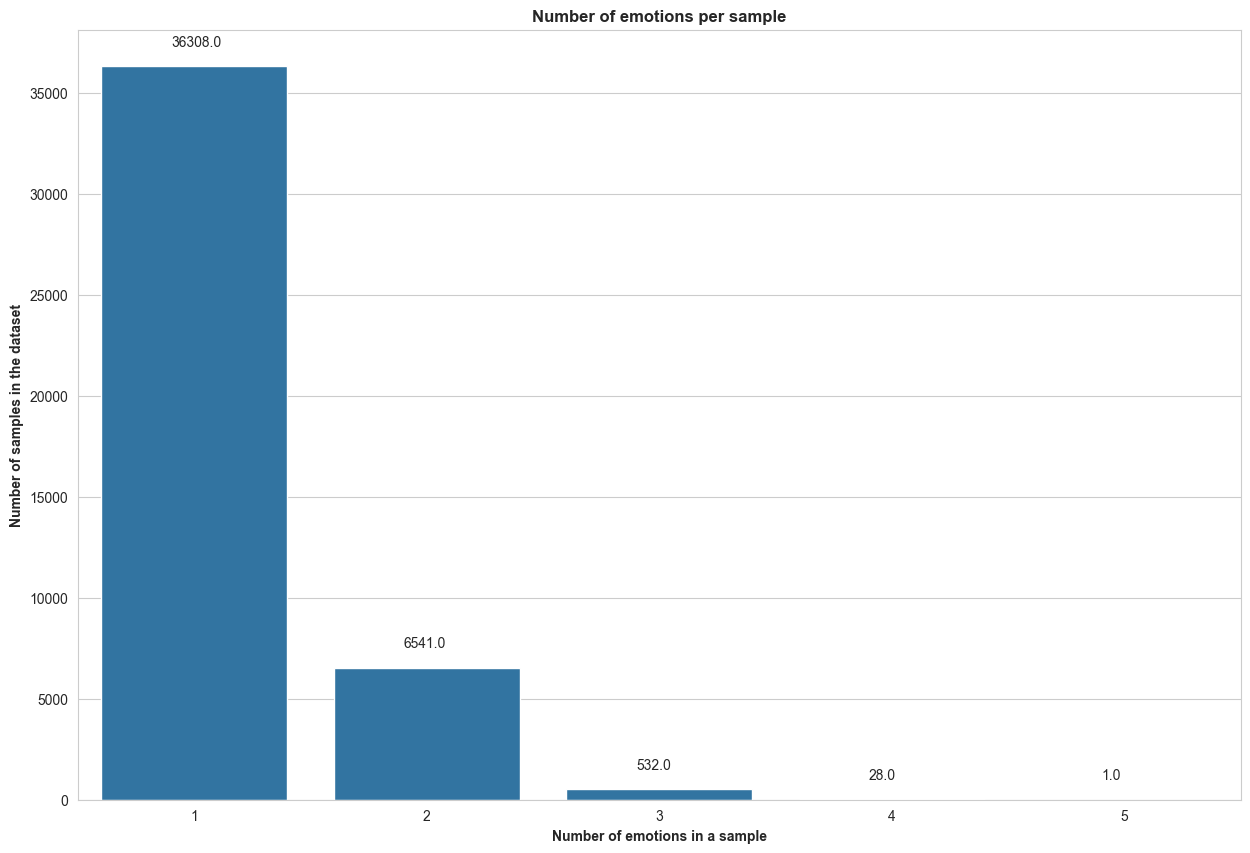

In [28]:
# Cardinality of GoEmotions and Ekman labels across the dataset
plt.figure(figsize=(15,10))

ax = sns.countplot(x='Cardinality', data=train_GE)

for p in ax.patches:
  value = p.get_height()
  x = p.get_x() + p.get_width() - 0.5
  y = p.get_y() + p.get_height() + 1000
  ax.annotate(value, (x, y))


plt.title("Number of emotions per sample", fontweight='bold')
plt.ylabel("Number of samples in the dataset", fontweight='bold')
plt.xlabel("Number of emotions in a sample", fontweight='bold')
plt.show()

### 4.1.2 - Number of samples per emotion in the dataset

Another interesting thing to do is to see how many samples we have for each emotion. This will also give us an idea of the classes balancing in our train dataset.

In [29]:
# Computing number of samples per emotion
classes_GE_count = train_GE.loc[:,GE_taxonomy].sum(axis=0).sort_values(ascending=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11980\2586885888.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=classes_GE_count.values, y=classes_GE_count.index, orient='h', palette="Blues_d")


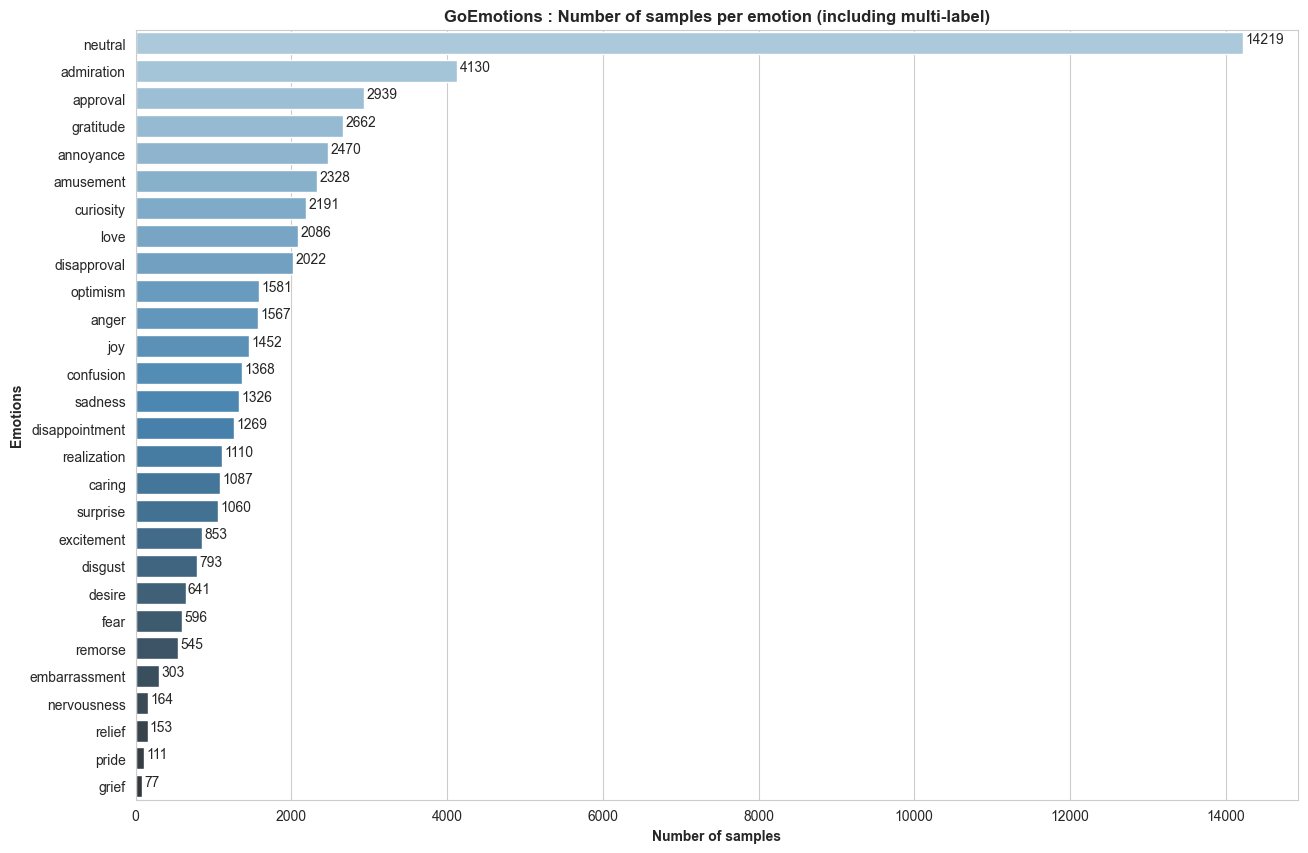

In [30]:
# Visualizing the number of samples per classes
plt.figure(figsize=(15,10))
ax = sns.barplot(x=classes_GE_count.values, y=classes_GE_count.index, orient='h', palette="Blues_d")

for p in ax.patches:
  value = int(p.get_width())
  x = p.get_x() + p.get_width() + 30
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("GoEmotions : Number of samples per emotion (including multi-label)", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Number of samples", fontweight='bold')
plt.show()

As we can see, we have an important skew in our train data as almost 30% of samples are flagged as 'Neutral' and only 77 samples have the 'grief' label.

### 4.1.3 - Classe balance accross train, validation and test datasets

We saw that our train dataset is unbalanced in terms of detected emotions. This is a common issue that is encountered in classification problems and can be delt with later on. However, **we have to make sure that the proportions of each emotion in the validation and test datasets are identical to the ones in the train dataset**. 

First, let's compute these proportions for each dataset.

In [31]:
# Defining classes representation for each dataset (GoEmotions)
train_count_GE = (train_GE.loc[:, GE_taxonomy].sum(axis=0) / size_train)*100
val_count_GE = (val_GE.loc[:, GE_taxonomy].sum(axis=0) / size_val)*100
test_count_GE = (test_GE.loc[:, GE_taxonomy].sum(axis=0) / size_test)*100

# Constructing a unique dataset for visualization purposes
balance_GE = pd.DataFrame(data=[train_count_GE, val_count_GE, test_count_GE]).T.reset_index(drop=False)
balance_GE.columns = ['Emotion', 'Train', 'Validation', 'Test']
balance_GE = balance_GE.sort_values('Train', ascending=False)
balance_GE = balance_GE.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train','Validation', 'Test'], value_name='Percentage')

# Preview of data
display(balance_GE.head())

,Emotion,Dataset,Percentage
0,neutral,Train,32.755126
1,admiration,Train,9.513937
2,approval,Train,6.770329
3,gratitude,Train,6.132228
4,annoyance,Train,5.689933


We can now visualize the data to compare the proportions.

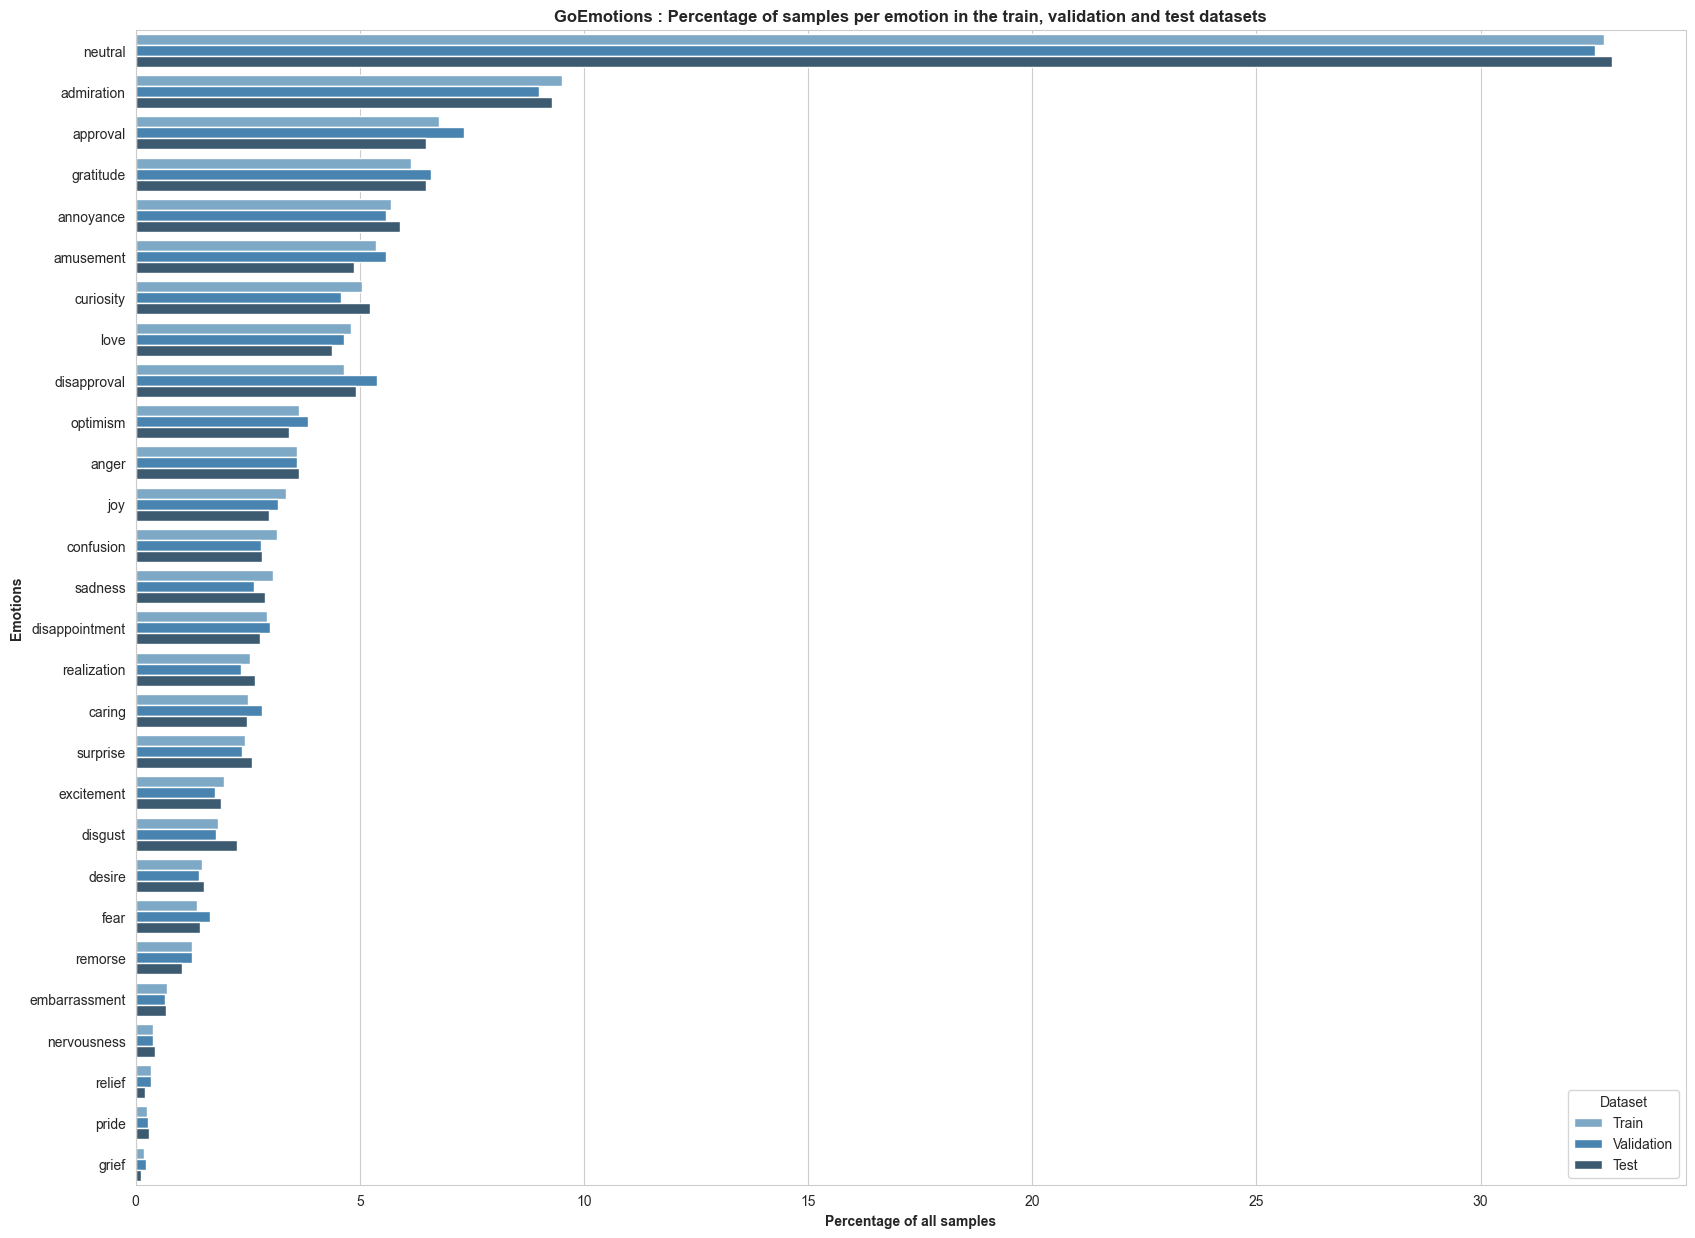

In [32]:
# Classe Balance visualization on GoEmotions
plt.figure(figsize=(20,15))
sns.barplot(x='Percentage', y='Emotion', data=balance_GE, orient='h', hue='Dataset', palette="Blues_d")
plt.title("GoEmotions : Percentage of samples per emotion in the train, validation and test datasets", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Percentage of all samples", fontweight='bold')
plt.show()

As we can see, **we maintain the same proportions of emotions** between the train, valisation and test datasets. This is important in order to not include an additional bias when evaluating our predictive models.

## 4.2 - Words analysis

### 4.2.1 - Mean length of samples per emotion

Let's see if there is any correlation between the length of a sample and the detected emotions.

First, we need to compute the number of words for each sample.

In [33]:
# Computing the number of words per sample
train_GE['Nb_words'] = train_GE['Clean_text'].apply(lambda x: len(x.split()))

# Preview of data
display(train_GE.head(3))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11980\2355761035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_GE['Nb_words'] = train_GE['Clean_text'].apply(lambda x: len(x.split()))


,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,Cardinality,Nb_words
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,12
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,20
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6


Now, we can create a dataframe that computes for each emotion the mean length of the samples and visualize the results.

In [34]:
# Computing the mean number of words per emotion
mean_nb_words = {}
for emo in GE_taxonomy:
  nb = train_GE['Nb_words'].loc[train_GE[emo]==1].mean()
  mean_nb_words[emo] = round(nb,2)

# Putting it in a Dataframe
df_length_GE = pd.DataFrame.from_dict(mean_nb_words, orient='index')
df_length_GE.columns = ['Mean_length']
df_length_GE.sort_values('Mean_length', ascending=False, inplace=True)

df_length_GE.head()

,Mean_length
optimism,16.37
realization,15.93
confusion,15.77
desire,15.28
disappointment,15.15


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11980\2659287416.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_length_GE['Mean_length'], y=df_length_GE.index, orient='h', palette="Blues_d")


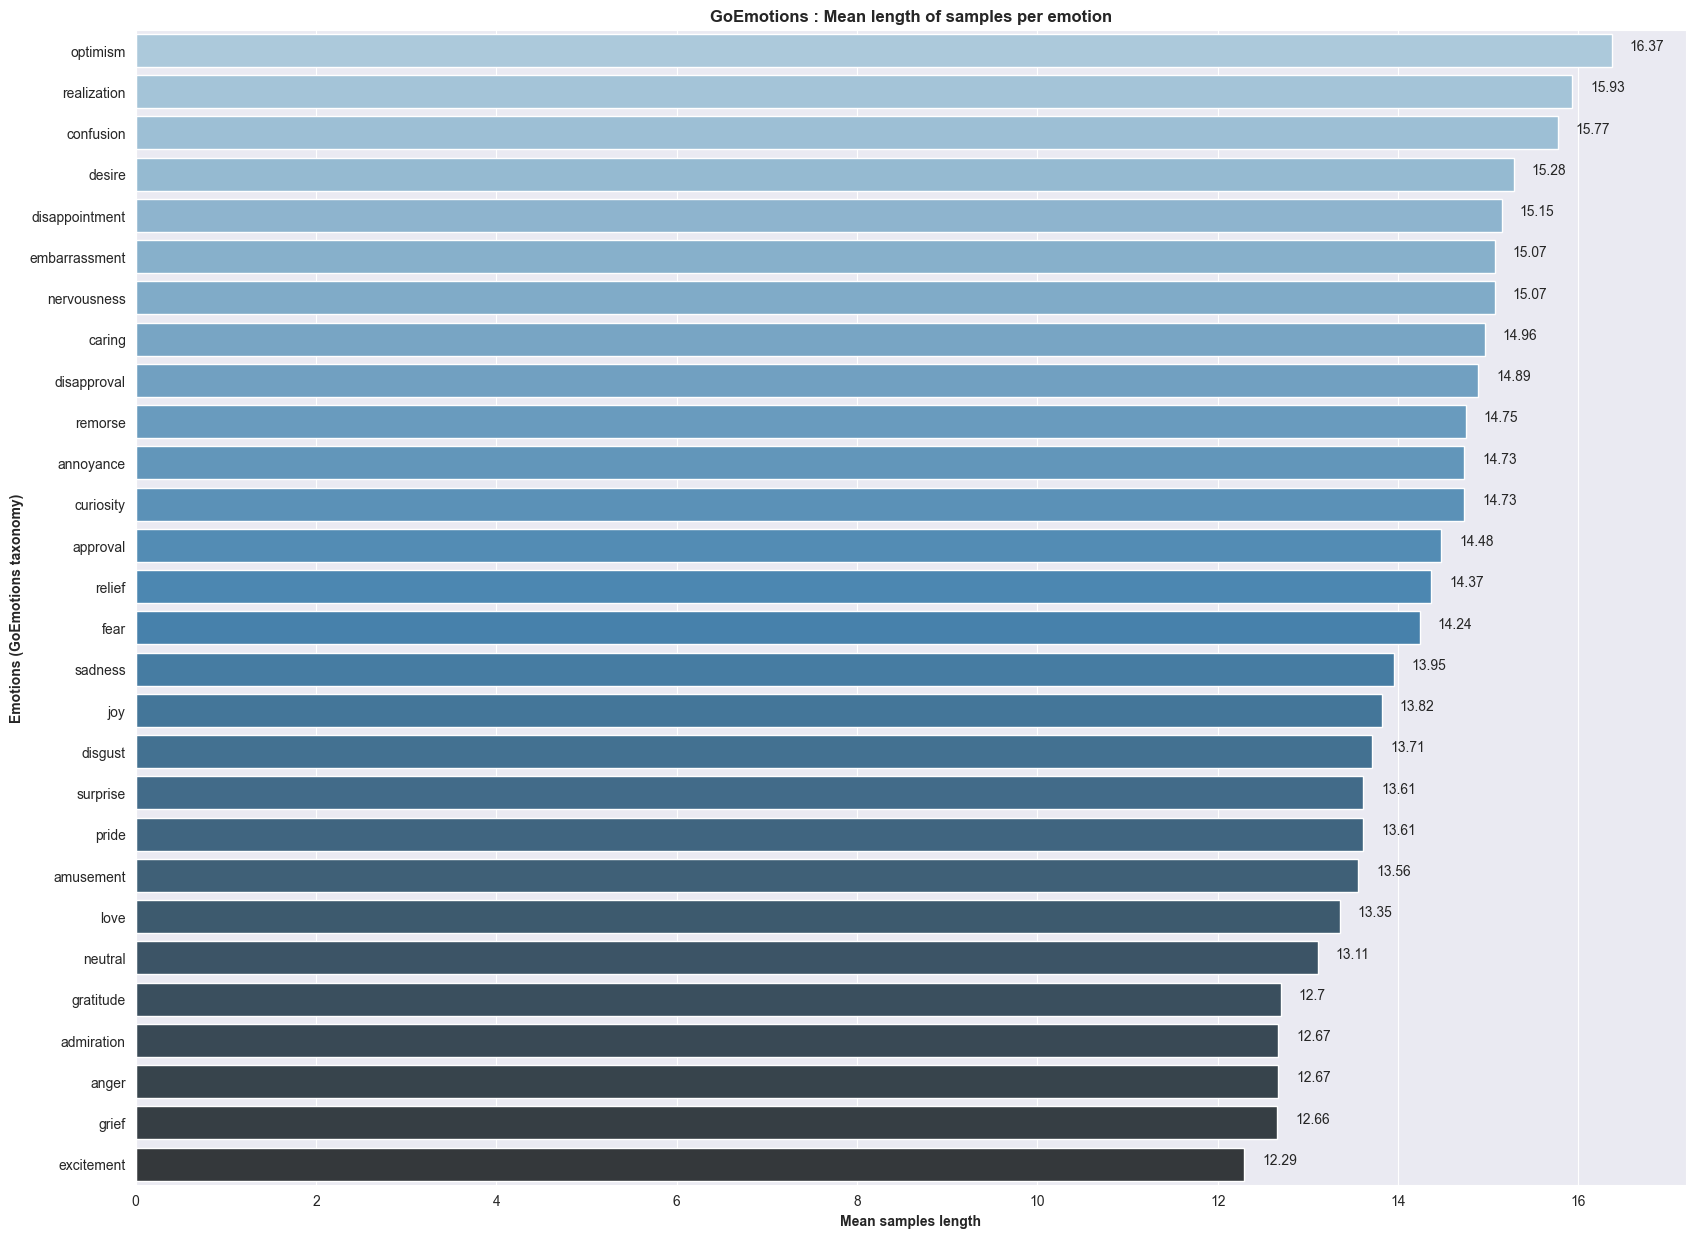

In [35]:
# Visualizing the mean length of samples per emotion
plt.figure(figsize=(20,15))

ax = sns.barplot(x=df_length_GE['Mean_length'], y=df_length_GE.index, orient='h', palette="Blues_d")
for p in ax.patches:
  value = p.get_width()
  x = p.get_x() + p.get_width() + 0.2
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("GoEmotions : Mean length of samples per emotion", fontweight='bold')
plt.ylabel("Emotions (GoEmotions taxonomy)", fontweight='bold')
plt.xlabel("Mean samples length", fontweight='bold')
plt.show()

Looking at the results, **we cannot concluded on any correlation between the length of a comment and the emotions detected**.

### 4.2.2 - Top words per emotion

However, we can legimately try and visualize the words that occure the most for each emotion.

Let's first define a function that plots the top 1O words in a given *series* of comments.

In [36]:
# Function to display 10 most frequent words in a list of comments
def plot_top_words_barchart(comments, axes):

    comments = comments.str.split() # split each comment into a list of words
    comments = comments.values.tolist() # from pandas series to lists of words
    corpus = [word for sample in comments for word in sample if word not in list(STOP_WORDS)+["?","!","name"]] # giant corpus of words excluding special characters
    counter = Counter(corpus) # create a counter
    most = counter.most_common(10) # retrieve the 10 most frequent words

    # Plot the 10 top words and their frequencies
    most = [(word, count) for (word, count) in most]
    x, y = [], []
    for word, count in most[:10]:
      x.append(word)
      y.append(count)       
    sns.barplot(x=y, y=x , ax=axes, palette="Set2")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11980\3650303669.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x , ax=axes, palette="Set2")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11980\3650303669.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x , ax=axes, palette="Set2")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11980\3650303669.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x , ax=axes, palette="Set2")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11980\3650303669.py:16: FutureWarning: 

Passing 

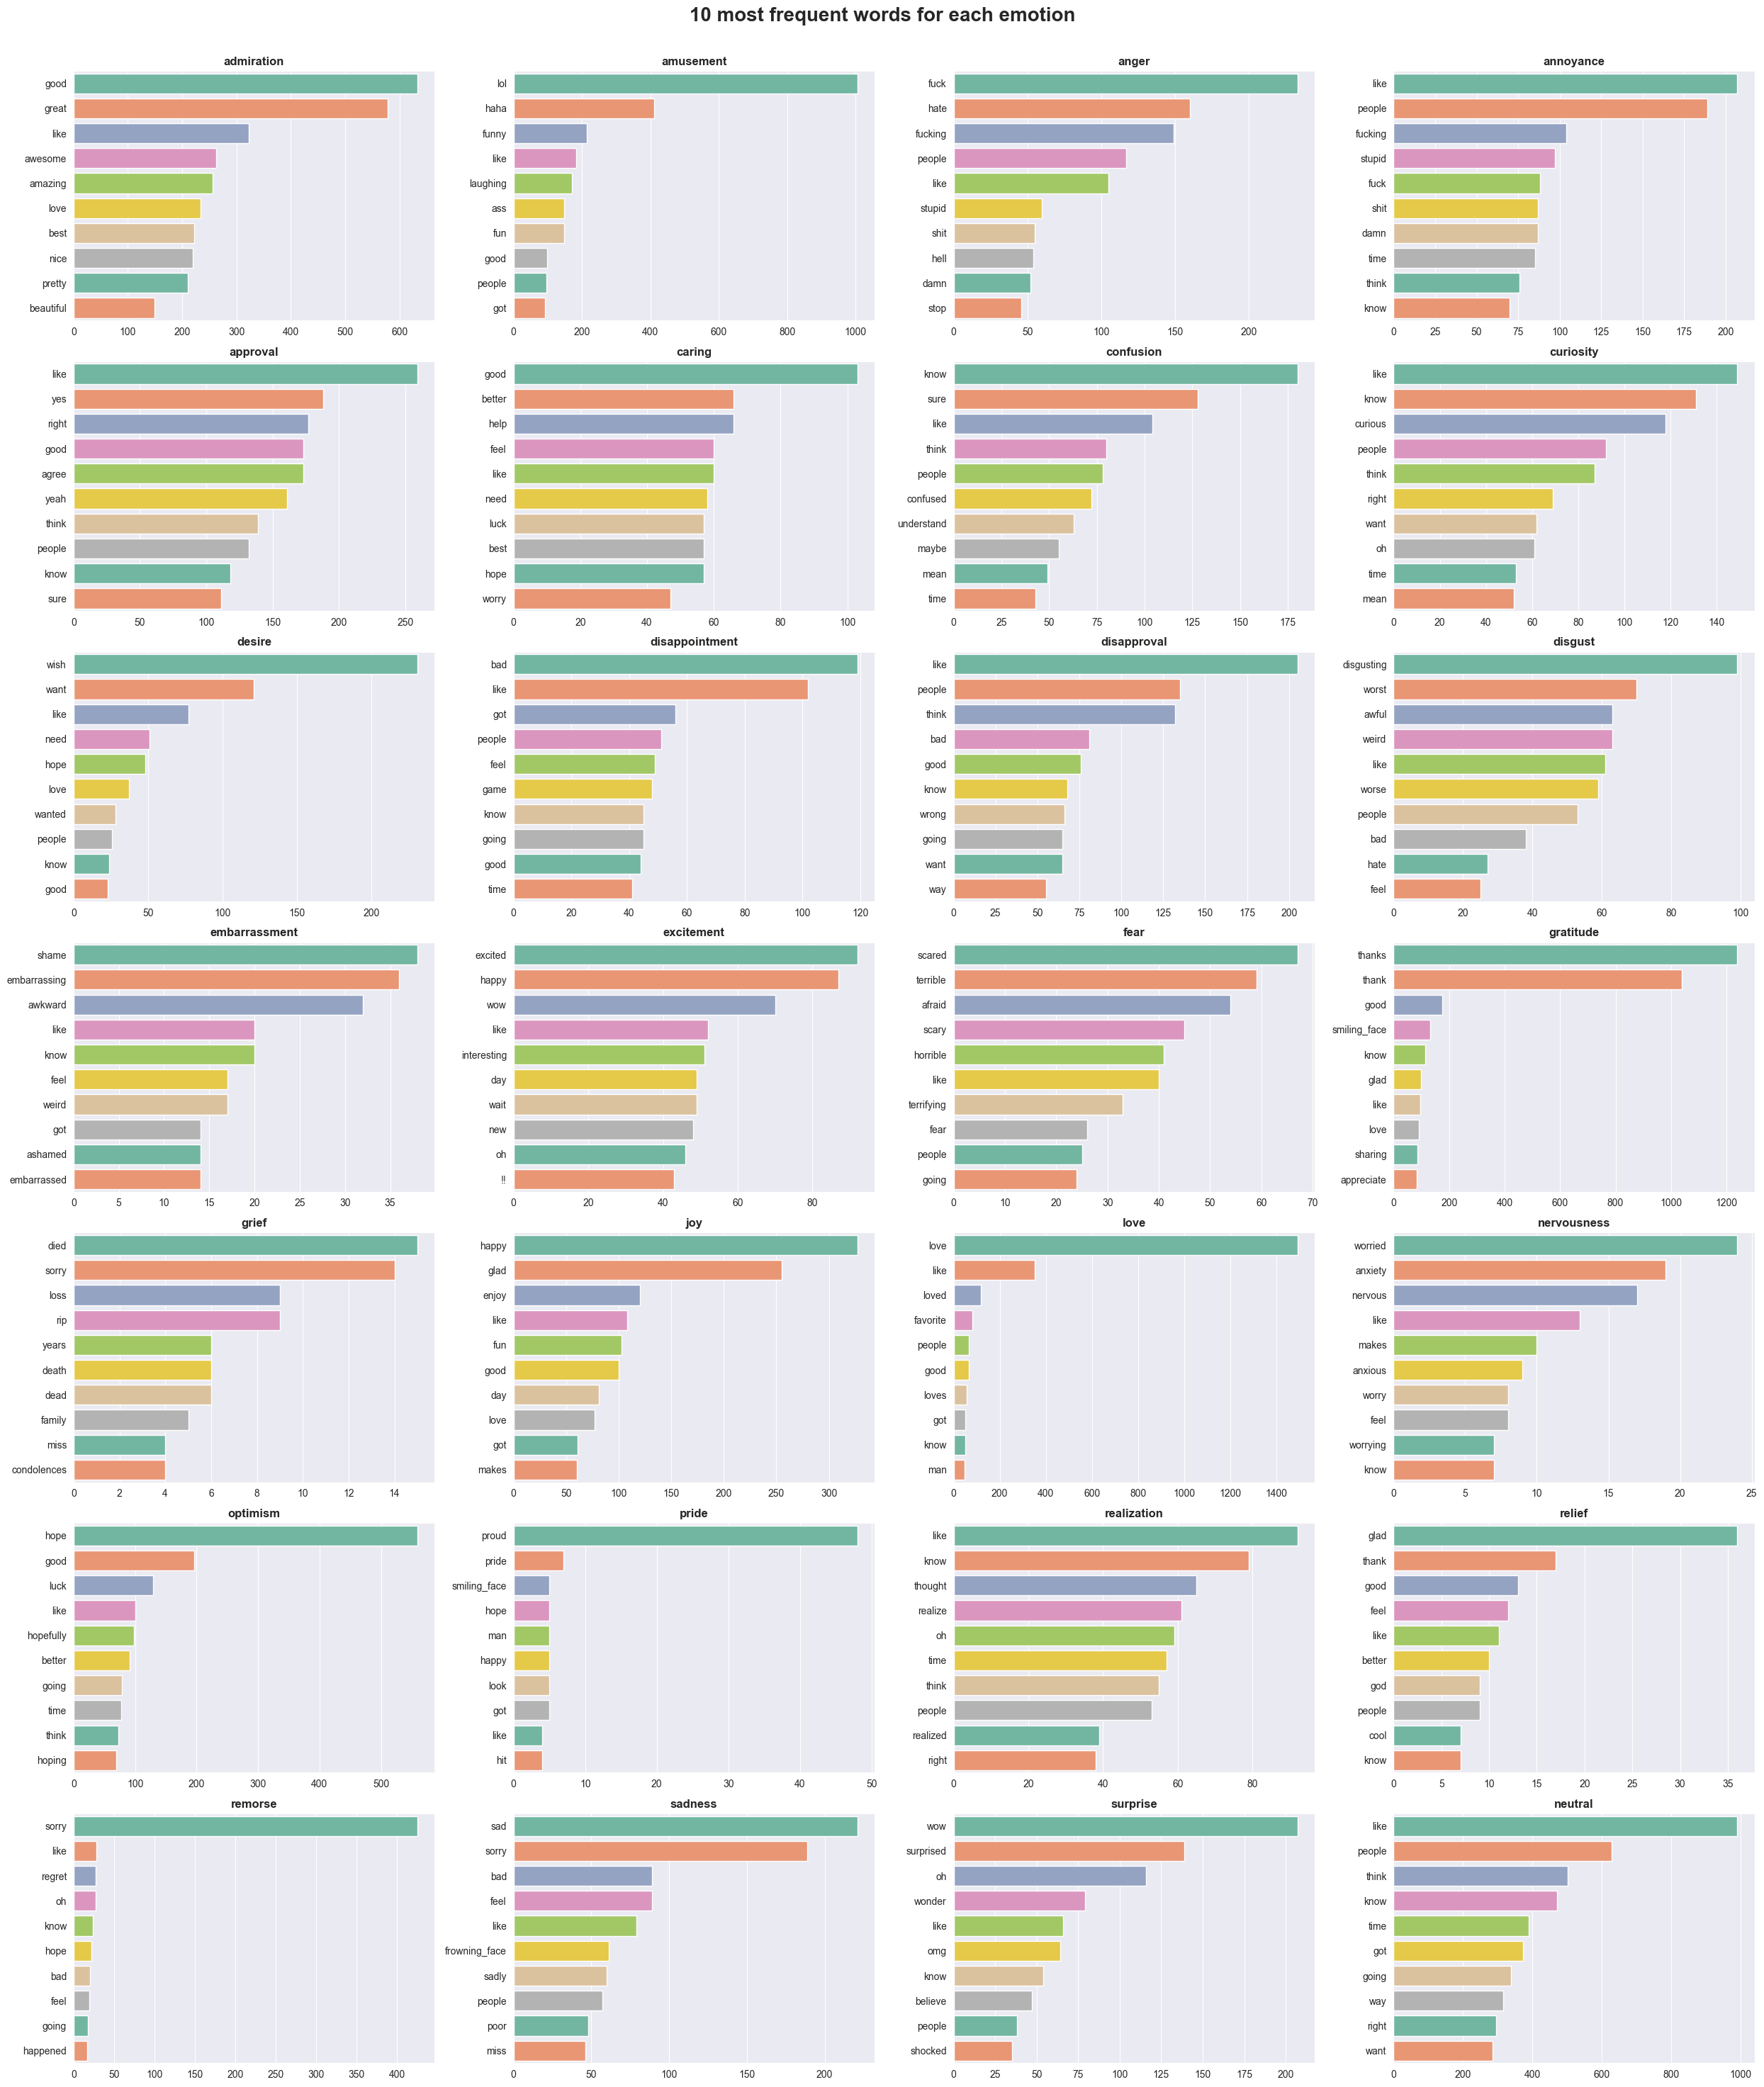

In [37]:
# Displaying 10 most frequent words for each emotion
fig, axes = plt.subplots(7, 4, figsize=(25, 30))
fig.suptitle('10 most frequent words for each emotion', fontweight="bold", fontsize=20)

for i, axi in enumerate(axes.flat):
    plot_top_words_barchart(train_GE.loc[train_GE[GE_taxonomy[i]]==1,"Clean_text"], axi)
    axi.set_title(GE_taxonomy[i], fontweight="bold")

plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

There are no surprises in the results as we can see the that **the top words are mostly representative of the detected**.

# 5 - Exporting Data

Let's save our data in preparation for the next step : Creating a baseline model for emotions detection.

In [38]:
# Droping unecessary columns
train_GE = train_GE[ ['Clean_text'] + GE_taxonomy ]

# Saving datasets for modeling
train_GE.to_csv("C:/Users/Lenovo/Desktop/Machine Learning/Final Project/text_emotions_detection-main/text_emotions_detection-main/data/train_clean.csv", index = False)
val_GE.to_csv("C:/Users/Lenovo/Desktop/Machine Learning/Final Project/text_emotions_detection-main/text_emotions_detection-main/data/val_clean.csv", index = False)
test_GE.to_csv("C:/Users/Lenovo/Desktop/Machine Learning/Final Project/text_emotions_detection-main/text_emotions_detection-main/data/test_clean.csv", index = False)